# Atomic cluster expansion (ACE)

Please read sources for more details:

* [Documentation](https://pacemaker.readthedocs.io/en/latest/)
* [`pacemaker` repository](https://github.com/ICAMS/python-ace)
* [Bochkarev, A., Lysogorskiy, Y., Menon, S., Qamar, M., Mrovec, M. and Drautz, R. Efficient parametrization of the atomic cluster expansion. Physical Review Materials 6(1) 013804 (2022)](https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.6.013804)
* [Lysogorskiy, Y., Oord, C. v. d., Bochkarev, A., Menon, S., Rinaldi, M., Hammerschmidt, T., Mrovec, M., Thompson, A., Csányi, G., Ortner, C. and  Drautz, R. Performant implementation of the atomic cluster expansion (PACE) and application to copper and silicon. npj Computational Materials 7(1), 1-12 (2021)](https://www.nature.com/articles/s41524-021-00559-9)
* [Drautz, R. Atomic cluster expansion for accurate and transferable interatomic potentials. Physical Review B, 99(1), 014104 (2019)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.014104)



## Import and load

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyiron import Project

In [3]:
from collections import Counter

In [4]:
import pandas as pd

In [5]:
pr = Project('fit_pace')

In [57]:
#pr.remove_jobs(silently=True)

In [7]:
pr_data = Project("../../introduction/training")

## Loading training containers (select smaller training subset for example)

In [8]:
training_container = pr_data['full']

In [9]:
df=training_container.to_pandas()

In [10]:
df["energy_per_atom"]=df["energy"]/df["number_of_atoms"]
df["comp_dict"]=df["atoms"].map(lambda at: Counter(at.get_chemical_symbols()))
for el in ["Al","Li"]:
    df["n"+el]=df["comp_dict"].map(lambda d: d.get(el,0))
    df["c"+el]=df["n"+el]/df["number_of_atoms"]

Select only Al-fcc

In [11]:
al_fcc_df = df[df["name"].str.contains("Al_fcc")]
al_fcc_df.shape

(134, 12)

only Li-bcc

In [12]:
li_bcc_df = df[df["name"].str.contains("Li_bcc")]
li_bcc_df.shape

(179, 12)

and AlLi structures that are within 0.1 eV/atom above AlLi ground state (min.energy structure)

In [13]:
alli_df = df[df["cAl"]==0.5]
alli_df=alli_df[alli_df["energy_per_atom"]<=alli_df["energy_per_atom"].min()+0.1]
alli_df.shape

(178, 12)

In [14]:
small_training_df = pd.concat([al_fcc_df, li_bcc_df, alli_df])

In [15]:
small_training_df.shape

(491, 12)

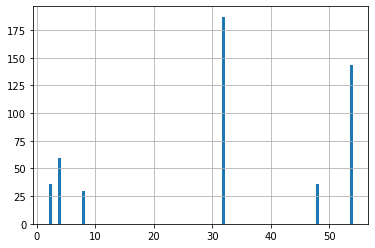

In [16]:
small_training_df["number_of_atoms"].hist(bins=100);

Select only sctructures smaller than **40** atoms per structures

In [17]:
small_training_df=small_training_df[small_training_df["number_of_atoms"]<=40].sample(n=100, random_state=42)

In [18]:
small_training_df.shape

(100, 12)

Pack them into training container

In [19]:
small_tc = pr.create.job.TrainingContainer("small_AlLi_training_container", delete_existing_job=True)

In [20]:
small_tc.include_dataset(small_training_df)

In [21]:
small_tc.save()

The job small_AlLi_training_container was saved and received the ID: 27


27

,V,E,space_group,crystal_system
0,18.537039,-2.714437,194,hexagonal
1,17.014115,-3.415845,1,triclinic
2,18.132856,-3.449419,225,cubic
3,18.512802,-3.413774,1,triclinic
4,20.298508,-3.178243,1,triclinic
...,...,...,...,...
95,15.707664,-2.800103,227,cubic
96,18.722061,-3.399934,1,triclinic
97,16.388387,-2.746841,1,triclinic
98,16.697821,-3.450689,1,triclinic


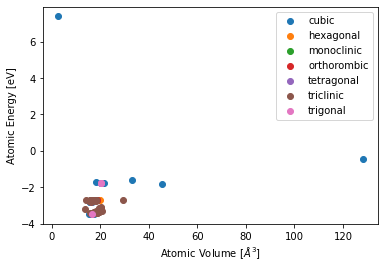

In [22]:
small_tc.plot.energy_volume(crystal_systems=True)

### Create PacemakerJob

In [23]:
job = pr.create.job.PacemakerJob("pacemaker_job")

In [24]:
job.add_training_data(small_tc)

Set maximum cutoff for the potential

### PACE potential fitting setup

#### Overview of settings

In [25]:
job.input

,Parameter,Value,Comment
0,cutoff,7.0,
1,metadata,{'comment': 'pyiron-generated fitting job'},
2,data,{},
3,potential,"{'elements': [], 'bonds': {'ALL': {'radbase': 'SBessel', 'rcut': 7.0, 'dcut': 0.01, 'radparameters': [5.25]}}, 'embeddings': {'ALL': {'fs_parameters': [1, 1, 1, 0.5], 'ndensity': 2, 'npot': 'Finni...",
4,fit,"{'loss': {'L1_coeffs': 1e-08, 'L2_coeffs': 1e-08, 'kappa': 0.3, 'w0_rad': 0, 'w1_rad': 0, 'w2_rad': 0}, 'maxiter': 1000, 'optimizer': 'BFGS', 'fit_cycles': 1}",
5,backend,"{'batch_size': 100, 'display_step': 50, 'evaluator': 'tensorpot'}",


#### Potential interatomic distance cutoff

In [26]:
job.cutoff=7.0

### Specification of ACE potential

PACE potential specification consists of three parts:


#### 1. Embeddings
 i.e. how atomic energy $E_i$ depends on ACE properties/densities $\varphi$. Linear expansion $E_i = \varphi$ is the trivial. Non-linear expansion, i.e. those, containing square root, gives more flexiblity and accuracy of final potential

Embeddings for `ALL` species (i.e. Al and Li): 
- non-linear `FinnisSinclairShiftedScaled`
- 2 densities
- fs_parameters': [1, 1, 1, 0.5]:
$$E_i = 1.0 * \varphi(1)^1 + 1.0 * \varphi(2)^{0.5} = \varphi^{(1)} + \sqrt{\varphi^{(2)}} $$

In [27]:
job.input["potential"]["embeddings"]

{'ALL': {'fs_parameters': [1, 1, 1, 0.5],
  'ndensity': 2,
  'npot': 'FinnisSinclairShiftedScaled'}}

#### 2. Radial functions

Radial functions are orthogonal polynoms example:
* (a) Exponentially-scaled Chebyshev polynomials (λ = 5.25)
* (b) Power-law scaled Chebyshev polynomials (λ = 2.0)
* (c) Simplified spherical Bessel functions

![ACE radial functions](img/radial-functions-low.png "ACE radial functions")

Radial functions specification for `ALL` species pairs (i.e. Al-Al, Al-Li, Li-Al, Li-Li):

* based on the Simplified Bessel
* cutoff $r_c=7.0$

In [28]:
job.input["potential"]["bonds"]

{'ALL': {'radbase': 'SBessel',
  'rcut': 7.0,
  'dcut': 0.01,
  'radparameters': [5.25]}}

#### 3. B-basis functions

B-basis functions  for `ALL` species type interactions, i.e. Al-Al, Al-Li, Li-Al, Li-Li blocks:
* maximum order = 4, i.e. body-order 5 (1 central atom + 4 neighbour  densities)
* nradmax_by_orders: 15, 3, 2, 1
* lmax_by_orders: 0, 3, 2, 1

In [29]:
job.input["potential"]["functions"]

{'ALL': {'nradmax_by_orders': [15, 3, 2, 1], 'lmax_by_orders': [0, 3, 2, 1]}}

We will reduce the basis size for demonstartion purposes

In [30]:
job.input["potential"]["functions"]={'ALL': {'nradmax_by_orders': [15, 3, 2], 'lmax_by_orders': [0, 2, 1]}}

### Fit/loss specification

Loss function specification

![Loss function](img/loss-func.png "Loss function")

![Loss regularization](img/loss-reg.png "Loss regularization")

In [31]:
job.input["fit"]['loss']

{'L1_coeffs': 1e-08,
 'L2_coeffs': 1e-08,
 'kappa': 0.3,
 'w0_rad': 0,
 'w1_rad': 0,
 'w2_rad': 0}

#### Weighting

Energy-based weighting puts more "accent" onto the low energy-lying structures, close to convex hull

In [32]:
job.input["fit"]['weighting'] =  {
        ## weights for the structures energies/forces are associated according to the distance to E_min:
        ## convex hull ( energy: convex_hull) or minimal energy per atom (energy: cohesive)
        "type": "EnergyBasedWeightingPolicy",
        ## number of structures to randomly select from the initial dataset
        "nfit": 10000,         
        ## only the structures with energy up to E_min + DEup will be selected
        "DEup": 10.0,  ## eV, upper energy range (E_min + DElow, E_min + DEup)        
        ## only the structures with maximal force on atom  up to DFup will be selected
        "DFup": 50.0, ## eV/A
        ## lower energy range (E_min, E_min + DElow)
        "DElow": 1.0,  ## eV
        ## delta_E  shift for weights, see paper
        "DE": 1.0,
        ## delta_F  shift for weights, see paper
        "DF": 1.0,
        ## 0<wlow<1 or None: if provided, the renormalization weights of the structures on lower energy range (see DElow)
        "wlow": 0.75,        
        ##  "convex_hull" or "cohesive" : method to compute the E_min
        "energy": "convex_hull",        
        ## structures types: all (default), bulk or cluster
        "reftype": "all",        
        ## random number seed
        "seed": 42 
}

### Minimization and backend specification

![Loss function](img/tensorpotential.png "Tensorpotential")

Type of optimizer: `SciPy.minimize.BFGS`. This optimizer is more efficient that typical optimizers for neural networks (i.e. ADAM, RMSprop, Adagrad, etc.), but it scales quadratically wrt. number of optimizable parameters.
However number of trainable parameters for PACE potential is usually up to few thousands, so we gain a lot of accuracy during training with BFGS optimizer.

In [33]:
job.input["fit"]["optimizer"]

'BFGS'

Maximum number of iterations by minimizer. Typical values are ~1000-1500, but we chose small value for demonstration purposes only

In [34]:
job.input["fit"]["maxiter"]=100

Batch size (number of simultaneously considered structures). This number should be reduced if there is not enough memory

In [35]:
job.input["backend"]["batch_size"]

100

For more details about these and other settings please refer to [official documentation](https://pacemaker.readthedocs.io/en/latest/pacemaker/inputfile/)

## Run fit

In [36]:
job.run()

INFO:pyiron_log:run job: pacemaker_job id: 28, status: created
INFO:pyiron_log:job: pacemaker_job id: 28, status: submitted, run job (modal)


Set automatically determined list of elements: ['Al', 'Li']
The job pacemaker_job was saved and received the ID: 28


INFO:pyiron_log:job: pacemaker_job id: 28, status: collect, output: /srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
2022-06-06 19:44:42,455 - root

In [37]:
pr.job_table()

DEBUG:pyiron_log:sql_query: {'project': '/home/jovyan/potentials/potentials/03-ACE/fit_pace/%'}


,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,27,created,None,small_AlLi_training_container,/small_AlLi_training_container,None,/home/jovyan/potentials/potentials/03-ACE/fit_pace/,2022-06-06 19:44:39.811609,NaT,NaN,pyiron@jupyter-yury-2elysogorskiy#1,TrainingContainer,0.4,None,None
1,28,finished,None,pacemaker_job,/pacemaker_job,None,/home/jovyan/potentials/potentials/03-ACE/fit_pace/,2022-06-06 19:44:41.494972,2022-06-06 19:48:30.460638,228.0,pyiron@jupyter-yury-2elysogorskiy#1,Pacemaker2022,0.2,None,None


## Analyse fit

plot loss function

[]

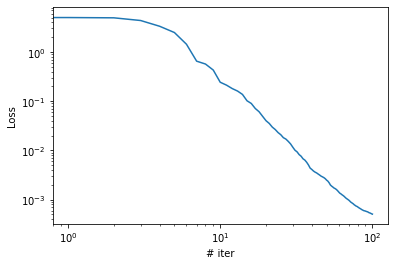

In [38]:
plt.plot(job["output/log/loss"])
plt.xlabel("# iter")
plt.ylabel("Loss")
plt.loglog()

plot energy per atom RMSE

[]

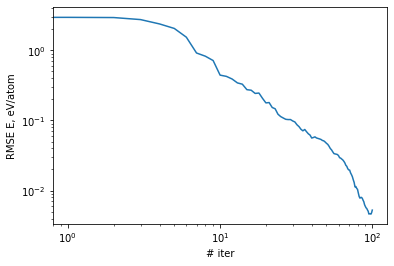

In [39]:
plt.plot(job["output/log/rmse_epa"])
plt.xlabel("# iter")
plt.ylabel("RMSE E, eV/atom")
plt.loglog()

plot force component RMSE

[]

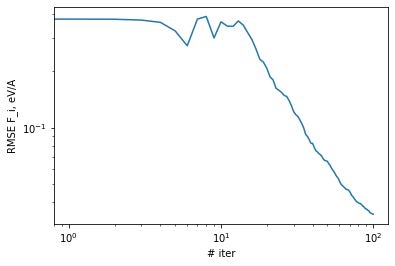

In [40]:
plt.plot(job["output/log/rmse_f_comp"])
plt.xlabel("# iter")
plt.ylabel("RMSE F_i, eV/A")
plt.loglog()

load DataFrame with predictions

In [41]:
ref_df = job.training_data

In [42]:
pred_df = job.predicted_data

Text(0, 0.5, 'ACE E, eV/atom')

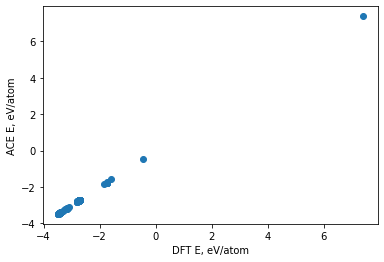

In [43]:
plt.scatter(pred_df["energy_per_atom_true"],pred_df["energy_per_atom"])
plt.xlabel("DFT E, eV/atom")
plt.ylabel("ACE E, eV/atom")

Text(0, 0.5, 'ACE F_i, eV/A')

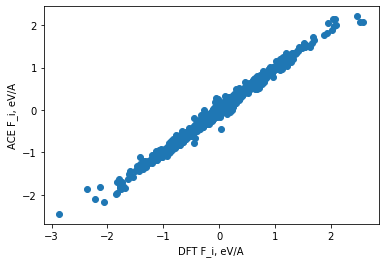

In [44]:
plt.scatter(ref_df["forces"],pred_df["forces"])
plt.xlabel("DFT F_i, eV/A")
plt.ylabel("ACE F_i, eV/A")

Check more in `job.working_directory`/report folder

In [45]:
! ls {job.working_directory}/report

train_E-dE-dist.png  train_EF-pairplots.png  train_Fi-dFi-dist.png
train_E-dE-nn.png    train_F-dF-dist.png


## How actual potential file looks like ?

`output_potential.yaml`:

```yaml
species:
    # Pure Al interaction block
  - speciesblock: Al
    radbase: SBessel
    radcoefficients: [[[1.995274603767268, -1.1940566258712266,...]]]
  
    nbody:
      # first order/ two-body functions = pair functions
      - {type: Al Al, nr: [1], nl: [0], c: [2.0970219095074687, -3.9539202281610351]}
      - {type: Al Al, nr: [2], nl: [0], c: [-1.8968648691718397, -2.3146574133175974]}
      - {type: Al Al, nr: [3], nl: [0], c: [1.3504952496800906, 1.5291190439028692]}
      - {type: Al Al, nr: [4], nl: [0], c: [0.040517989827027742, 0.11933504671036224]}
      ...
      # second order/ three-body functions 
      - {type: Al Al Al, nr: [1, 1], nl: [0, 0], c: [0.57788490809100468, -1.8642896163994958]}
      - {type: Al Al Al, nr: [1, 1], nl: [1, 1], c: [-1.0126646532267587, -1.2336078784112348]}
      - {type: Al Al Al, nr: [1, 1], nl: [2, 2], c: [-0.19324470046809467, 0.63954472122968498]}
      - {type: Al Al Al, nr: [1, 1], nl: [3, 3], c: [-0.22018334529075642, 0.32822679746839439]}
      ...
      # fifth order/ six-body functions 
      - {type: Al Al Al Al Al Al, nr: [1, 1, 1, 1, 1], nl: [0, 0, 0, 0, 0], lint: [0, 0, 0], c: [-0.71...]}
  
  
  # binary Al-Li interaction block    
  - speciesblock: Al Li      
     ...
     nbody:
      - {type: Al Li, nr: [1], nl: [0], c: [0.91843424537280882, -2.4170371138562308]}
      - {type: Al Li, nr: [2], nl: [0], c: [-0.88380210517336399, -0.97055273167339651]}
      ...
      - {type: Al Al Al Li Li, nr: [1, 1, 1, 1], nl: [1, 1, 0, 0], lint: [0, 0], c: [-0.0050,...]}
      ...
  # Pure Li interaction block      
  - speciesblock: Li
      nbody:
       ...
       - {type: Li Li Li, nr: [4, 4], nl: [3, 3], c: [-0.0059111333449957159, 0.035]}
       - {type: Li Li Li Li, nr: [1, 1, 1], nl: [0, 0, 0], lint: [0], c: [0.210,...]}
       ...
  # binary Al-Li interaction block    
  - speciesblock: Li Al
      nbody:
       ...
       - {type: Li Al Al, nr: [4, 4], nl: [3, 3], c: [0.014680736321211739, -0.030618474343919122]}
       - {type: Li Al Li, nr: [1, 1], nl: [0, 0], c: [-0.22827705573988896, 0.28367909613209036]}
       ...
  
```

`output_potential.yaml` is in B-basis form. For efficient LAMMPS implementaion it should be converted to so-called `C-tilde` form.  This is already done by `pyiron`, but it could be also done manually by `pace_yaml2yace` utility. Check [here](https://pacemaker.readthedocs.io/en/latest/pacemaker/quickstart/#lammps) for more details

## Get LAMMPS potential and try some calculations

In [46]:
pace_lammps_potential = job.get_lammps_potential()
pace_lammps_potential

,Config,Filename,Model,Name,Species
0,"[pair_style pace\n, pair_coeff * * /home/jovyan/potentials/potentials/03-ACE/fit_pace/pacemaker_job_hdf5/pacemaker_job/output_potential.yace Al Li\n]",,ACE,pacemaker_job,"[Al, Li]"


In [47]:
lammps_job = pr.create.job.Lammps("pace_lammps", delete_existing_job=True)

In [48]:
lammps_job.structure=pr.create.structure.bulk("Al", cubic=True)

In [49]:
lammps_job.structure[0]='Li'

In [51]:
lammps_job.potential=pace_lammps_potential

In [52]:
murn=pr.create.job.Murnaghan("LiAl_murn")

In [53]:
murn.ref_job = lammps_job

In [ ]:
murn.run()

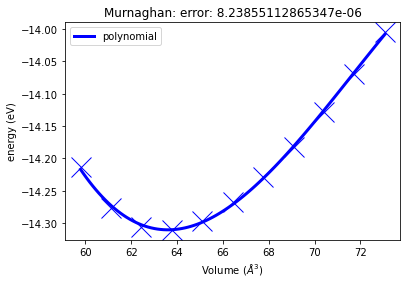

<AxesSubplot:title={'center':'Murnaghan: error: 8.23855112865347e-06'}, xlabel='Volume ($\\AA^3$)', ylabel='energy (eV)'>

In [55]:
murn.plot()

## Further reading

Please read sources for more details:
* [Documentation](https://pacemaker.readthedocs.io/en/latest/)
* [`pacemaker` repository](https://github.com/ICAMS/python-ace)
* [Bochkarev, A., Lysogorskiy, Y., Menon, S., Qamar, M., Mrovec, M. and Drautz, R. Efficient parametrization of the atomic cluster expansion. Physical Review Materials 6(1) 013804 (2022)](https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.6.013804)
* [Lysogorskiy, Y., Oord, C. v. d., Bochkarev, A., Menon, S., Rinaldi, M., Hammerschmidt, T., Mrovec, M., Thompson, A., Csányi, G., Ortner, C. and  Drautz, R. Performant implementation of the atomic cluster expansion (PACE) and application to copper and silicon. npj Computational Materials 7(1), 1-12 (2021)](https://www.nature.com/articles/s41524-021-00559-9)
* [Drautz, R. Atomic cluster expansion for accurate and transferable interatomic potentials. Physical Review B, 99(1), 014104 (2019)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.014104)

